In [1]:
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import random
from sklearn.neighbors import KernelDensity
import math

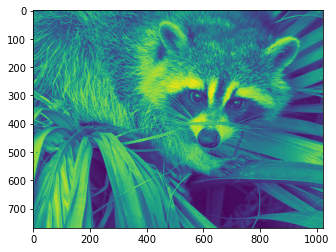

In [2]:
face = scipy.misc.face(gray=True)
plt.imshow(face)

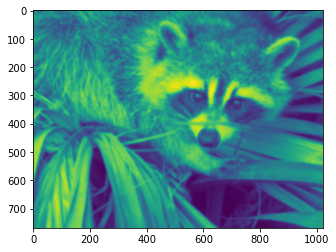

In [3]:
blurred_face = ndimage.gaussian_filter(face, sigma=3)
plt.imshow(blurred_face)

In [4]:
linearize_image = blurred_face.flatten().reshape((-1, 1))
pdf = linearize_image / np.sum(linearize_image)
cdf = np.cumsum(pdf)

In [5]:
## Test_Previous Code
###Sampling
sample_num = 100000
x = 1/sample_num
u_cdf = []
u=0
for i in range (0,sample_num):
    u_cdf.append(u)
    u += x
ucdf_array = np.array(u_cdf)
print(ucdf_array[1000:1010])
print(ucdf_array.shape)

[0.01    0.01001 0.01002 0.01003 0.01004 0.01005 0.01006 0.01007 0.01008
 0.01009]
(100000,)


In [92]:
### New
np.random.seed(1)
sample_num = 100000
ucdf_array = np.random.uniform(0, 1, sample_num)
# count, bins, ignored = plt.hist(ucdf_array, 1000, density=True)
# bins[990:998]
print(ucdf_array[1000:1010])
print(ucdf_array.shape)

[0.32580997 0.88982734 0.75170772 0.7626321  0.46947903 0.2107645
 0.04147508 0.3218288  0.03711266 0.69385541]
(100000,)


In [6]:
### Test
cdf = cdf.reshape(-1, 1)
np.argwhere((cdf >= 0.40700219-.0004) & (cdf <= 0.40700219+.0004)).shape
#np.searchsorted(cdf, 0.13784603)


(566, 2)

In [7]:
## Test
pixel_position = []
for i in range (0,len(bins)):
    pixels = np.argwhere((cdf >= bins[i]-0.0004) & (cdf <= bins[i]+0.0004))
    for j in range (0,len(pixels)):
        pixel_position.append(pixels[j,0])

In [97]:
## Test
p = np.array(pixel_position)
print(p[5000:5010])
print(p.shape)

[505453 567589  27684 769508  81143 457780 126346 384377  82935 580661]
(100000,)


In [41]:
### Test
np.argwhere(p == 6221)
#np.where(p == 6218)

array([[5007]], dtype=int64)

In [6]:
## Previos + New
pixel_position = []
for i in range (0,sample_num):
    q = np.searchsorted(cdf, ucdf_array[i])
    pixel_position.append(q)
print(pixel_position[70000:70010])

[520672, 520679, 520686, 520693, 520700, 520707, 520712, 520718, 520723, 520729]


In [29]:
## Test
p = np.array(pixel_position)
len(np.argwhere(p == 720812))

1

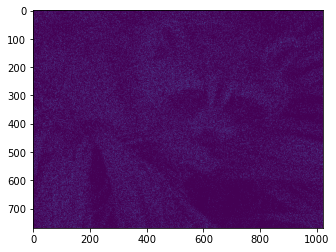

In [98]:
## New
new_image = np.empty((face.shape[0]*face.shape[1],1))
pixel_position_array = np.array(pixel_position).reshape((-1,1))

for i in range (0, sample_num):
    x = pixel_position[i]
    if new_image[x,0] == 0:
        new_image[x,0] = new_image[x,0] + len(np.argwhere(pixel_position_array == x))
    else:
        pass

new_image_2d = (np.reshape(new_image.squeeze(), (face.shape[0], face.shape[1]))).astype(np.uint8)

plt.imshow(new_image_2d)
plt.show()

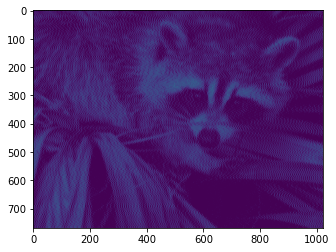

In [7]:
### Test Previous Code
new_image = np.empty((face.shape[0]*face.shape[1],1))
# sampled_density = np.zeros((face.shape[0]*face.shape[1],1))
#sample_index = np.zeros((face.shape[0]*face.shape[1],1))
sampled_density = []
sample_index = []

for i in range (0, sample_num):
    x = pixel_position[i]
    new_image[x,0] = linearize_image[x]
#     point = (lambda p : 1 if (p>0) else 0)
#     new_image[x,0] = point(pdf[x])
#     sampled_density[x, 0] = pdf[x]
#     sample_index[x, 0] = x
#     sampled_density.append(linearize_image[x])
#     sampled_density.append(pdf[x])



new_image_2d = (np.reshape(new_image.squeeze(), (face.shape[0], face.shape[1]))).astype(np.uint8)

pixel_position_array = np.array(pixel_position).reshape((-1,1))

#plt.subplot(1, 3, 3)
plt.imshow(new_image_2d)
plt.show()

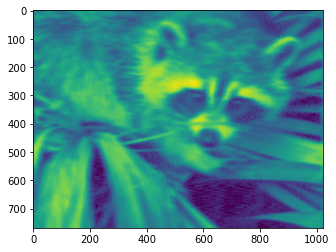

In [8]:
## Build Kernel
xaxis = np.arange(0, len(pdf)).reshape((-1,1))
kde = KernelDensity(kernel = 'tophat', bandwidth = 15).fit(pixel_position_array)
pdf_vals = np.exp(kde.score_samples(xaxis))
im_2d = (np.reshape(pdf_vals.squeeze(), (face.shape[0], face.shape[1])))
plt.imshow(im_2d)
plt.show()

In [9]:
from sklearn.model_selection import KFold
n_splits=10
kf = KFold(n_splits)

In [70]:
####Test
from sklearn.model_selection import cross_val_score
cross_val_score(KernelDensity(kernel = 'tophat', bandwidth = 9), pixel_position_array, cv=10)

array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])

In [10]:
def get_score(model, train, test):
    model.fit(train)
    return np.exp(model.score_samples(test))

In [11]:
def calculate_log(kde_list):
    kde_array = np.array(kde_list)
    total = 0
    for i in range (0, kde_array.shape[0]):
        for j in range (0, kde_array.shape[1]):
            if kde_array[i,j]!=0:
                total = math.log(kde_array[i,j]) + total
            else:
                pass
    return total

In [12]:
from sklearn.model_selection import KFold
n_splits=5
kf = KFold(n_splits)

kde_b = []
probability = []
band = [9, 15, 25]

for b in range (0,len(band)):
    kde_b = []
    for train_index, test_index in kf.split(pixel_position_array):
        train, test = pixel_position_array[train_index], pixel_position_array[test_index]
        kde_b.append(get_score(KernelDensity(kernel = 'tophat', bandwidth = band[b]), train, test))
    probability.append(math.exp(calculate_log(kde_b)))

In [13]:
print(probability)


[2.1635157172958224e-49, 6.845498949255908e-88, 4.1438852349527175e-177]
